<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/augment8%2Fresnet-single/ResNet_base_model_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/2020 Kaggle Study/data/Copy of train.npy' train.npy

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
warnings.filterwarnings("ignore")
# style 설정
plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 데이터 받아오기

In [0]:
#train = np.load('train.npy')
train = np.load('train.npy')

In [3]:
train.shape

(76345, 40, 40, 15)

#모델 만들기

In [0]:
def create_model():
    inputs=Input((40, 40, 10))
    
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(inputs)
    conv0=Dropout(0.5)(conv0)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    conv=Dropout(0.5)(conv)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    conv=Dropout(0.5)(conv)
    concat=concatenate([concat, conv], axis=3)

    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        conv=Dropout(0.5)(conv)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

## 데이터 제네레이터 만들기

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.025, random_state=7777)
train = np.concatenate((train[:, :, :, :10], train[:, :, :, -1:]), axis=3)  
def preprocess(data):
    # Normalize sensor data
    #data[:,:,:,:9] = scaler.transform(data[:,:,:,:9].reshape(-1, 9)).reshape(-1, 40, 40, 9)

    # Land type
    land_type_data = data[:,:,:,9]
    data[:,:,:,9] = np.where(land_type_data//100 == 2, 0.7,
                             np.where(land_type_data//100 == 3, 0.3,
                                      land_type_data//100))
    return data
# -9999를 포함한 이미지, 강수인 지역이 300픽셀 미만인 이미지 제거
# land type이 ocean이 아닌 이미지 살리기
is_valid = (train[:,:,:,-1].reshape(-1, 1600) >= 0.1).sum(axis=1) >= 300
is_valid = is_valid | ((train[:,:,:,9].reshape(-1, 1600) >= 100).sum(axis=1) >= 300)
is_valid = is_valid & ((train[:,:,:,-1].reshape(-1, 1600) < 0).sum(axis=1) == 0)
train = train[is_valid]  # (-1, 40, 40, 15)
train.shape
train = preprocess(train)
val = preprocess(val)

In [0]:
import tensorflow as tf, tensorflow.keras.backend as K
import math

def get_mat():
    # returns 3x3 transformmatrix which transforms indicies
    # CONVERT DEGREES TO RADIANS
    rotation = tf.random.uniform([1], minval=0, maxval=4, dtype=tf.dtypes.int32, seed=None, name=None) / 2 * math.pi

    # ROTATION MATRIX
    rotation = tf.random.uniform([1], minval=0, maxval=4, dtype=tf.dtypes.int32, seed=None, name=None)
    rotation = tf.cast(rotation, 'float32')
    rotation = rotation * math.pi / 2.
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # TRANSPOSE MATRIX 
    de_t = tf.random.uniform([1], minval = 0, maxval = 2, dtype = tf.int32)
    de_t = tf.cast(de_t, 'float32')
    forty = tf.constant([40],dtype='float32')
    transpose_matrix = tf.reshape( tf.concat([1 - de_t, -de_t, forty*de_t, -de_t, 1 - de_t, forty*de_t, zero, zero, zero], axis = 0),[3,3])
    
    return rotation_matrix#K.dot(rotation_matrix, transpose_matrix)

def transform(train_x,train_y):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = 40

    # GET TRANSFORMATION MATRIX
    m = get_mat() 

    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )

    train_x_img = tf.gather_nd(train_x,tf.transpose(idx3))
    train_y_img = tf.gather_nd(train_y,tf.transpose(idx3))

    return tf.reshape(train_x_img,[DIM,DIM,10]),tf.reshape(train_y_img,[DIM,DIM,1])

def get_training_dataset(dataset,batch_size = None):
    dataset = dataset.with_options(tf.data.Options())
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset,batch_size = None):
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [0]:
 model = tf.keras.models.load_model('/content/model_trainonly_4.h5')

In [0]:
maeOverFscore(model.predict(train[3000:6000,:,:,:-1]),train[3000:6000,:,:,-1])

5.742136346415955

(8, 40, 40, 10)
(8, 40, 40, 10)
(8, 40, 40, 10)


<Figure size 1080x504 with 0 Axes>

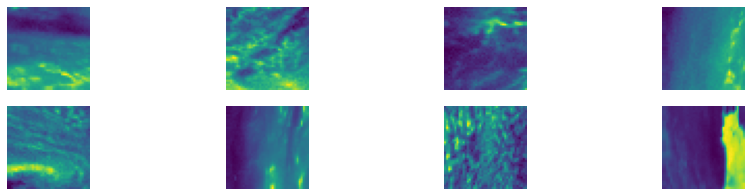

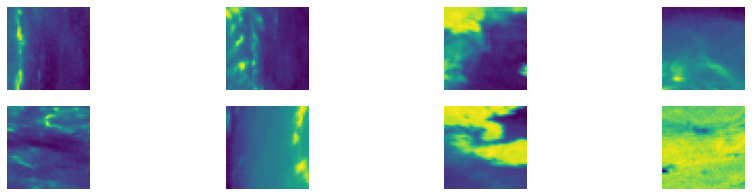

In [27]:
x_train =train[:1000,:,:,:-1]
y_train = train[:1000,:,:,-1].reshape(-1,40,40,1)

train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_batches = get_training_dataset(train_batches, batch_size = 8)

n = 0 
for (img_x,label) in train_batches:
    plt.figure(figsize=(15,int(15*2/4)))
    print(img_x.shape)
    if n == 1:
        for j in range(8):
            plt.subplot(4,4,j+1)
            plt.axis('off')
            plt.imshow(img_x[j,:,:,4])
    if n == 2:
        for j in range(8):
            plt.subplot(4,4,j+1+8)
            plt.axis('off')
            plt.imshow(img_x[j,:,:,4])
    if n == 2:
        break
    n = n+1

In [0]:
import pandas as pd
import numpy as np
import random
import sys
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model

test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')  # float64
gmi_preci = np.load('/content/drive/My Drive/2020 Kaggle Study/data/gmi_preci/near2.npy')  # float32
train[:, :, :, -1] = gmi_preci.reshape(-1, 40, 40)
train, val = train_test_split(train, test_size=0.025, random_state=7777)

In [6]:
scaler = StandardScaler()
scaler.fit(train[:,:,:,:9].reshape(-1, 9))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
def preprocess(data):
    # Normalize sensor data
    data[:,:,:,:9] = scaler.transform(data[:,:,:,:9].reshape(-1, 9)).reshape(-1, 40, 40, 9)

    # Land type
    land_type_data = data[:,:,:,9]
    data[:,:,:,9] = np.where(land_type_data//100 == 2, 0.7,
                             np.where(land_type_data//100 == 3, 0.3,
                                      land_type_data//100))
    return data

In [0]:
is_valid = (train[:,:,:,-1].reshape(-1, 1600) < 0).sum(axis=1) == 0
is_valid = is_valid & ((train[:,:,:,-1].reshape(-1, 1600) >= 0.1).sum(axis=1) >= 50)
train = train[is_valid]  # (-1, 40, 40, 15)

In [0]:
train = preprocess(train)
val = preprocess(val)

In [0]:

from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score
def create_model():
    inputs=Input((40, 40, 10))
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)

    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
def custom_mae(y_true, y_pred):
    y_error = y_pred - y_true
    bool_idx = tf.less_equal(0.1,y_true)
    len_mae = tf.reduce_sum(tf.cast(bool_idx, tf.float32))
    socre = tf.math.abs(y_error)
    mae = tf.keras.backend.switch(bool_idx, socre, 0)
    return tf.divide(tf.math.reduce_sum(mae), len_mae)

In [43]:
tf.less_equal(y_true, 0.1)

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([False, False, False, False])>

In [0]:
y_true = tf.convert_to_tensor([0.2,0.5,0.7,0.5])
y_pred = tf.convert_to_tensor([0.2,0.3,0.4,0.5])

In [45]:
### tensor로 score matric 구현

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def custom_mae(y_true, y_pred):
    y_error = y_pred - y_true
    bool_idx = tf.less_equal(0.1,y_true)
    len_mae = tf.reduce_sum(tf.cast(bool_idx, tf.float32))
    socre = tf.math.abs(y_error)
    mae = tf.keras.backend.switch(bool_idx, socre, 0)
    return tf.divide(tf.math.reduce_sum(mae), len_mae)


def maeOverFscore(y_true, y_pred):
    f1_score = f1_metric(y_true, y_pred) + 1e-07
    return tf.divide(custom_mae(y_true, y_pred), f1_score)

<tf.Tensor: shape=(), dtype=float32, numpy=0.12499999>

In [56]:
import tensorflow as tf
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import KFold
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE

k_fold = KFold(n_splits=5, shuffle=True, random_state=7777)


model_number = 0
histories = []
for train_idx, val_idx in k_fold.split(train):
    print(f'Fold{model_number + 1}')
    x_val, y_val = train[val_idx, :, :, :10], train[val_idx, :, :, -1]
    models = []
    ### TPU 할당 및 초기화-------------------
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    ### 모델 생성 및 compile-------------------
    with strategy.scope():
        model = create_model()
        model.compile(optimizer = 'adam',loss = 'mae',
        metrics=[maeOverFscore, f1_metric, custom_mae]
        )
    ### 콜백 생성-------------------
    callbacks_list = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3,
            factor=0.8
        ),

        tf.keras.callbacks.ModelCheckpoint(
            filepath = f'model_{model_number}.h5',
            monitor='val_maeOverFscore',
            save_best_only=True
        )
    ]
    # batch_dataset 만들기------------------
    batch_size = 64
    #train_batch
    train_dataset = tf.data.Dataset.from_tensor_slices((train[train_idx, :, :, :10],
                                                        train[train_idx, :, :, -1]))
    train_dataset = get_training_dataset(train_dataset,
                                         batch_size = batch_size)
    #validation_batch
    validation_dataset = tf.data.Dataset.from_tensor_slices((train[val_idx, :, :, :10],
                                        train[val_idx, :, :, -1]))
    
    validation_dataset = get_validation_dataset(validation_dataset,
                                                batch_size = batch_size)
    ### model.fit-------------------
    history = model.fit(train_dataset, epochs=50,
            #batch_size=batch_size,
            steps_per_epoch = len(train[train_idx, :, :, :10])*8 // batch_size,
            validation_data=validation_dataset,
            callbacks=callbacks_list)
    
    histories.append(history)
    
    model_number = model_number + 1
    ### model append -------------------

Fold1


INFO:tensorflow:Initializing the TPU system: grpc://10.23.190.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.23.190.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
3219/3219 [==============================] - 139s 43ms/step - f1_metric: 0.6854 - maeOverFscore: 1.8844 - custom_mae: 1.2948 - loss: 0.2209 - val_f1_metric: 0.6998 - val_maeOverFscore: 1.7665 - val_custom_mae: 1.2449 - val_loss: 0.2125 - lr: 0.0010
Epoch 2/50
3219/3219 [==============================] - 132s 41ms/step - f1_metric: 0.7023 - maeOverFscore: 1.7110 - custom_mae: 1.2146 - loss: 0.2050 - val_f1_metric: 0.6996 - val_maeOverFscore: 1.7276 - val_custom_mae: 1.2191 - val_loss: 0.2078 - lr: 0.0010
Epoch 3/50
3219/3219 [==============================] - 132s 41ms/step - f1_metric: 0.7075 - maeOverFscore: 1.6594 - custom_mae: 1.1877 - loss: 0.2005 - val_f1_metric: 0.6997 - val_maeOverFscore: 1.7537 - val_custom_mae: 1.2402 - val_loss: 0.2101 - lr: 0.0010
Epoch 4/50
3219/3219 [==============================] - 133s 41ms/step - f1_metric: 0.7119 - maeOverFscore: 1.6227 - custom_mae: 1.1691 - loss: 0.1975 - val_f1_metric: 0.6993 - val_maeOverFscore: 1.6978 - val_custom_mae:

INFO:tensorflow:Initializing the TPU system: grpc://10.23.190.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.23.190.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/50
3219/3219 [==============================] - 143s 44ms/step - f1_metric: 0.6853 - maeOverFscore: 1.8942 - custom_mae: 1.2952 - loss: 0.2219 - val_f1_metric: 0.6948 - val_maeOverFscore: 1.7628 - val_custom_mae: 1.2373 - val_loss: 0.2099 - lr: 0.0010
Epoch 2/50
3219/3219 [==============================] - 132s 41ms/step - f1_metric: 0.7041 - maeOverFscore: 1.7021 - custom_mae: 1.2102 - loss: 0.2048 - val_f1_metric: 0.6980 - val_maeOverFscore: 1.8084 - val_custom_mae: 1.2780 - val_loss: 0.2150 - lr: 0.0010
Epoch 3/50
3219/3219 [==============================] - 133s 41ms/step - f1_metric: 0.7096 - maeOverFscore: 1.6517 - custom_mae: 1.1852 - loss: 0.2003 - val_f1_metric: 0.7011 - val_maeOverFscore: 1.7248 - val_custom_mae: 1.2239 - val_loss: 0.2060 - lr: 0.0010
Epoch 4/50
3219/3219 [==============================] - 133s 41ms/step - f1_metric: 0.7126 - maeOverFscore: 1.6199 - custom_mae: 1.1677 - loss: 0.1974 - val_f1_metric: 0.7057 - val_maeOverFscore: 1.7199 - val_custom_mae:

KeyboardInterrupt: ignored